<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<b>Trans-Neptunian Objects (TNOs)</b> <br>
Contact author(s): Andrés A. Plazas Malagón<br>
Last verified to run: 07/10/2023 <br>
LSST Science Pipelines version: w_2023_28  <br>
Container Size: medium <br>
Targeted learning level: beginner <br>

**Description:** This tutorial studies the Trans-Neptunian Objects populations in DP0.3. 

**Skills:** Use of the DP0.3 catalogs to study TNO populations.

**LSST Data Products:**  DP0.3 catalogs: `SSObject`, `MPCORB`

**Packages:** lsst.afw.image, lsst.afw.detection, lsst.rsp, lsst.daf.butler, lsst.geom, lsst.afw.display, lsst.analysis.tools, lsst.pipe.base

**Credits:** Developed by Andrés A. Plazas Malagón in collaboration with Melissa Graham, the Rubin Community Science Team for DP0.3, and Pedro Bernardinelli (University of Washington). This tutorial is based on a Jupyter Notebook by Pedro Bernardinelli. 

This notebook has made used of suggestions in the [Accessible Authoring Checklist](https://iota-school.github.io/accessibility_hackathon/hack#checklist)

**Get Support:**
Find DP0-related documentation and resources at <a href="https://dp0-2.lsst.io">dp0-2.lsst.io</a>. Questions are welcome as new topics in the <a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> of the Rubin Community Forum. Rubin staff will respond to all questions posted there.

# Trans-Neptunian Objects in DP0.3

## Table of contents

1. Introduction.

1.1 Package Imports.

1.2 Functions and Parameters Definitions.

## 1. Introduction

### 1.1 Background

A trans-Neptunian object (TNO) is categorized as a minor planet within the Solar System. It orbits the Sun at an average distance greater than that of Neptune, which possesses a semi-major axis measuring approximately 30.1 astronomical units (AU). The population of minor bodies orbiting our Sun beyond Neptune are largely intact relics from the era of planetary formation. 

In the current model explaining the formation of the outer Solar System, the small building blocks of planets, called planetesimals, that eventually became TNOs can be categorized into two groups:

- Outwardly Migrated "Hot" TNOs: Some planetesimals formed within the inner region of the protoplanetary disk, located at a distance less than 30 Astronomical Units (AU) from the Sun. These planetesimals were later pushed outward by interactions with a migrating Neptune. As a result, they acquired dynamically "hot" orbits.

- In-Situ "Cold" TNOs: Other planetesimals formed directly in the trans-Neptunian region, where they remain with dynamically "cold" orbits.

There is a population of TNOs called the *Classical* TNOs situated between Neptune's 3:2 and 2:1 mean motion resonances, at distances ranging from 39 to 47 AU, and characterized by low eccentricity (e < ~ 0.3). This group is a mix of two types of objects: some are native and remained dynamically "cold," while others were originally "hot" objects that migrated into this region.

Another population is known as the *Scattering* TNOs, which can have orbits extending to large distances, but their orbits are currently experiencing significant variations due to perturbations caused by Neptune when their closest distance to the Sun (perihelia `q`) is less than approximately 40 AU. These Scattering TNOs are believed to be remnants of a population that was scattered during the early formation of the Solar System and have managed to survive for a long time.

*Resonant* TNOs are currently found in stable mean motion resonances with Neptune, meaning they have a specific orbital relationship with the planet. It is presumed that they were transported outward while maintaining their resonant positions as Neptune migrated during the early history of the Solar System.

In contrast, the *Detached* TNOs have higher perihelia and are dynamically independent from Neptune, as they currently maintain stable orbits that are not significantly influenced by Neptune's gravitational effects. These Detached TNOs might have originated as Scattering TNOs whose perihelia were raised through past resonance interactions with Neptune or through interactions with a distant, massive planet in the outer Solar System (though this hypothetical planet has not been observed yet). The "Detached" familie of TNOs is among the most enigmatic one, and the questions about where they formed and how they got to their orbits are still open.  

There is another class of TNOs referred to as *extreme*. These extreme TNOs are characterized by their exceptional distances from the Sun, with semi-major axes (a) exceeding 150 AU (note that definitions may vary slightly) and `q` > 40 AU.  The formation mechanism responsible for producing these distant extreme TNOs remains unclear. One prominent hypothesis involves the presence of a massive object often referred to as "Planet X" or "Planet 9" situated at approximately 400 AU from the Sun. The gravitational influence of this hypothetical Neptune-mass planet could have played a significant role in sculpting the distribution of these extreme TNOs, leading to the anisotropies observed in their orbital characteristics.


### 1.2 This tutorial

In this tutorial we'll primarly use the DP0.3 `MPCORB` catalog to identify the different TNO dynamical classes in eccentricy/inclination vs semi-major axis plots. We 'll aim to produce a similar plot to Fig. 8 in , which found nearly 800 TNOs in the Dark Energy Survey Y6 data. 

We'll then use the TNO orbital elements to visualize the orbits of a subset of the TNOs, including those of the "extreme" TNOs, 

#### Additional resources

DES Y6 TNO catalog: [Bernardinelli et al. 2022: A Search of the Full Six Years of the Dark Energy Survey for Outer Solar System Objects](https://ui.adsabs.harvard.edu/abs/2022ApJS..258...41B/abstract)

Review: [Gladmann and Volk, 2021: Transneptunian Space](https://ui.adsabs.harvard.edu/abs/2021ARA%26A..59..203G/abstract)

The Outer Solar System Origins Survey (OSSOS): [Banister et al 2018: OSSOS. VII. 800+ Trans-Neptunian Objects—The Complete Data Release](https://ui.adsabs.harvard.edu/abs/2018ApJS..236...18B/abstract)


### 1.3. Package Imports

The [matplotlib](https://matplotlib.org/) (and especially sublibrary `matplotlib.pyplot`), [numpy](http://www.numpy.org/), [scipy](https://scipy.org/https://scipy.org/), and [astropy](http://www.astropy.org/) libraries are widely used Python libraries for plotting, scientific computing, scientific analysis, and astronomical data analysis.

The `lsst.rsp` package provides access to the Table Access Protocol (TAP) service for queries to the DP0 catalogs.

The `lsst.afw.image` provide visualization tools.

The `lsst.afw.display` library provides access to image visualization routines and the `lsst.daf.butler` library is used to access data products via the butler.

The `lsst.afw.analysis.tools` library provides acces to analysis tools.

The `lsst.geom` library provides the representation of a 2D coordinate `Point2D`.

The `lsst.pipe.base` library provides access to the `lsst.pipe.base.Struct` container.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import matplotlib.colors as mcolors
from matplotlib import colormaps
from cycler import cycler
from matplotlib.patches import Polygon

from lsst.rsp import get_tap_service, retrieve_query

### 1.4 Functions and Parameters Definitions.

Neptune's mean semimajor axis

In [5]:
a_Neptune = 30.11

The following function estimates a Solar Sytem body's diameter in km from its solar system absolute magnitude, `H`, and albedo, `albedo`:

In [ ]:
def estDiamFromHandAlbedo(H, albedo=0.15):
    """Get solar system object size in km.
    
    Parameters
    ----------
    H : `float`
        Solar System absolute magnitude
    albedo: `float`
        Solar system object albedo
    
    Returns
    -------
    estDiam : `float`
        Estimated diameter of the object, in kilometers.
    """
    estDiam = np.power(10., 3.1236 - 0.5*np.log10(albedo) - 0.2*H)
    return estDiam

The following are helper functions to change the aesthetics of the eccentrivy/inclination vs semi-major axis plots. Taken from [Stack Overflow](https://stackoverflow.com/questions/29321835/is-it-possible-to-get-color-gradients-under-curve-in-matplotlib).

In [3]:
def gradient_fill(x, y, alpha=1, fill_color=None, ax=None, **kwargs):
    """
    Plot a line with a linear alpha gradient filled beneath it.

    Parameters
    ----------
    x, y : array-like
        The data values of the line.
    fill_color : a matplotlib color specifier (string, tuple) or None
        The color for the fill. If None, the color of the line will be used.
    ax : a matplotlib Axes instance
        The axes to plot on. If None, the current pyplot axes will be used.
    Additional arguments are passed on to matplotlib's ``plot`` function.

    Returns
    -------
    line : a Line2D instance
        The line plotted.
    im : an AxesImage instance
        The transparent gradient clipped to just the area beneath the curve.
    """
    if ax is None:
        ax = plt.gca()

    line, = ax.plot(x, y, alpha=0, **kwargs)
    if fill_color is None:
        fill_color = line.get_color()

    zorder = line.get_zorder()
    #alpha = line.get_alpha()
    #alpha = 1.0 if alpha is None else alpha

    z = np.empty((100, 1, 4), dtype=float)
    rgb = mcolors.colorConverter.to_rgb(fill_color)
    z[:,:,:3] = rgb
    z[:,:,-1] = np.linspace(0, alpha, 100)[:,None]

    xmin, xmax, ymin, ymax = x.min(), x.max(), y.min(), y.max()
    im = ax.imshow(z, aspect='auto', extent=[xmin, xmax, ymin, ymax],
                   origin='upper', zorder=zorder)

    xy = np.column_stack([x, y])
    xy = np.vstack([[xmin, ymin], xy, [xmax, ymin], [xmin, ymin]])
    clip_path = Polygon(xy, facecolor='none', edgecolor='none', closed=True)
    ax.add_patch(clip_path)
    im.set_clip_path(clip_path)

    #ax.autoscale(True)
    return line, im

def gradient_fill_inv(x, y, alpha=1, fill_color=None, ax=None, **kwargs):
    """
    Plot a line with a linear alpha gradient filled beneath it.

    Parameters
    ----------
    x, y : array-like
        The data values of the line.
    fill_color : a matplotlib color specifier (string, tuple) or None
        The color for the fill. If None, the color of the line will be used.
    ax : a matplotlib Axes instance
        The axes to plot on. If None, the current pyplot axes will be used.
    Additional arguments are passed on to matplotlib's ``plot`` function.

    Returns
    -------
    line : a Line2D instance
        The line plotted.
    im : an AxesImage instance
        The transparent gradient clipped to just the area beneath the curve.
    """
    if ax is None:
        ax = pl.gca()

    line, = ax.plot(x, y, alpha=0, **kwargs)
    if fill_color is None:
        fill_color = line.get_color()

    zorder = line.get_zorder()
    #alpha = line.get_alpha()
    #alpha = 1.0 if alpha is None else alpha

    z = np.empty((100, 1, 4), dtype=float)
    rgb = mcolors.colorConverter.to_rgb(fill_color)
    z[:,:,:3] = rgb
    z[:,:,-1] = np.linspace(0, alpha, 100)[:,None]

    xmin, xmax, ymin, ymax = x.min(), x.max(), y.min(), y.max()
    im = ax.imshow(z, aspect='auto', extent=[xmin, xmax, ymin, ymax],
                   origin='upper', zorder=zorder)

    xy = np.column_stack([x, y])
    xy = np.vstack([[xmax, ymax], xy, [xmin, ymax], [xmin, ymin]])
    clip_path = Polygon(xy, facecolor='none', edgecolor='none', closed=True)
    ax.add_patch(clip_path)
    im.set_clip_path(clip_path)

    #ax.autoscale(True)
    return line, im

The following function calculates mean motion resonances with Neptune, and plots them as vertical dashed line son a given plot axis.

In [9]:
def plot_resonances(ax, k, k_N, y_loc=None, a_shift=0.75, alpha=0.2):
    """Plot Neptune resonances.
    
    Parameters
    ----------
    ax : `matplotlib...`
       Figure axes.
    
    """
    a_res = a_Neptune * np.cbrt(float(k)**2/float(k_N)**2)
    ax.axvline(a_res, linewidth=2, alpha=alpha, linestyle='--')
    if y_loc is not None:
        ax.annotate(r'${}:{}$'.format(k, k_N),
                    (a_res + a_shift, y_loc), rotation=90, fontsize=16)
    return ax

In [24]:
%load_ext pycodestyle_magic
%flake8_on
import logging
logging.getLogger("flake8").setLevel(logging.FATAL)

The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


In [7]:
plt.style.use('tableau-colorblind10')

In [8]:
params = {'lines.linewidth': 2,
          'lines.linestyle': '-',
          'lines.color': 'black',
          'patch.linewidth': 2,
          'font.family': 'serif',
          'font.weight': 'medium',
          'font.size': 14.0,
          'text.color': 'black',
          'axes.edgecolor': 'black',
          'axes.linewidth': 2.0,
          'axes.grid': False,
          'axes.titlesize': 'xx-large',
          'axes.labelsize': 'xx-large',
          'axes.labelweight': 'medium',
          'axes.labelcolor': 'black',
          'axes.formatter.limits': (-4, 4),
          'xtick.major.size': 10,
          'xtick.minor.size': 5,
          'xtick.major.pad': 8,
          'xtick.minor.pad': 8,
          'xtick.labelsize': 'xx-large',
          'xtick.minor.width': 2.0,
          'xtick.major.width': 2.0,
          'xtick.minor.visible': True,
          'ytick.major.size': 10,
          'ytick.minor.size': 5,
          'ytick.major.pad': 8,
          'ytick.minor.pad': 8,
          'ytick.labelsize': 'xx-large',
          'ytick.minor.width': 1.0,
          'ytick.major.width': 1.0,
          'ytick.minor.visible': True,
          'axes.prop_cycle': cycler('color',
                                    ['xkcd:cerulean blue', 'xkcd:scarlet',
                                     'xkcd:grass green',
                                     'xkcd:light orange',
                                     'xkcd:lighter purple',
                                     'xkcd:bright aqua', 'xkcd:dirt brown',
                                     'xkcd:gunmetal',
                                     'xkcd:dark hot pink',
                                     'xkcd:very dark brown']),
          'legend.numpoints': 1,
          'legend.fontsize': 'x-large',
          'legend.shadow': False,
          'legend.frameon': True,
          'legend.fancybox': True,
          'figure.titlesize': 'xx-large',
          'figure.figsize': (8, 6),
          'figure.facecolor': 'white'}
plt.rcParams.update(params)

Let's get the TAP service. Notice how it is a different service form the DP0.2 simulations. 

In [11]:
service = get_tap_service("ssotap")

In this tutorial, the main catalog we'll use is use the Minor Planet Center orbital Elements DP0.3 catalog, `dp03_catalogs.MPCORB`. We'll start by looking at the contents of this catalog, including the columns descriptions. 

In [13]:
results = service.search("SELECT column_name, datatype, description, "
                         "unit from TAP_SCHEMA.columns "
                         "WHERE table_name = 'dp03_catalogs.MPCORB'")
results.to_table().to_pandas()

,column_name,datatype,description,unit
0,arc,float,"MPCORB: Arc (days), for single-opposition objects",d
1,arcEnd,char,MPCORB: Year of last observation (for multi-op...,
2,arcStart,char,MPCORB: Year of first observation (for multi-o...,
3,computer,char,MPCORB: Computer name,
4,e,double,MPCORB: Orbital eccentricity,
5,epoch,double,"MPCORB: Epoch (in MJD, .0 TT)",d
6,flags,int,MPCORB: 4-hexdigit flags. See https://minorpla...,
7,fullDesignation,char,MPCORB: Readable designation,
8,incl,double,"MPCORB: Inclination to the ecliptic, J2000.0 (...",deg
9,lastIncludedObservation,float,MPCORB: Date of last observation included in o...,d


We'll now request the object ID, the orbital elements, and the solar system absolute magnitude H, which is aproxy for size. The orbital elements that we will query are the eccentricity `e`, the inclination `incl` (degrees), the perihelion distance `q` (AU), the longitude of the ascending node `node`(degrees), and the argument of the perihelion `peri` (degrees). 

TNos, by definition, have a semi-major axis greater thanthe mean semi-amjor axis of Neptune `a_Neptune = 30.11 AU`. There's no `a` column in the `MPCORB` table, so we'll us ethe `q/(1 - e)` definiton in the `WHERE` clause of the query. This will speed things greatly---reducing the query time from several minutes to seconds---as the number of rows is reduced from about 14.6 million to 60000. Additionally, we will impose a cut on the minimum number of observations `numObs` (from the `SSObject`) from a given object, which will bring the final number of TNOs down to about 50000. this is about an order of magnitude grater than the current number of confirmed TNOs, which is consistent wth expectations and forecast for LSST Y10. 


In [14]:
num_obs = 10
tnos = service.search("SELECT mpc.ssObjectId, mpc.e, mpc.incl, mpc.mpcH, mpc.q, mpc.node, mpc.peri "
                                "FROM dp03_catalogs.MPCORB as mpc "
                                "JOIN dp03_catalogs.SSObject as sso "
                                "ON mpc.ssObjectId = sso.ssObjectId "
                                f"WHERE (mpc.q/(1-mpc.e) > {a_Neptune}) "
                                f"AND sso.numObs > {num_obs}"
                                "AND mpc.e < 1").to_table()

In [15]:
print(len(tnos))

48574


Let's define the semi-major axis `a`, as a function of the eccentricity `e` and perihelion distance `q`, and attach it as a new column in the retrieved table.

In [16]:
a = tnos['q']/(1.0-tnos['e'])
tnos['a'] = a

### Absolute H magnitude as a proxy for size

For solar system objects, particularly asteroids, the absolute magnitude is often referred to as the "H magnitude." It is defined as the apparent magnitude of the object when it is located at a distance of 1 astronomical unit (AU) from both the Sun and the observer. The H magnitude is specifically used for objects that primarily reflect sunlight, such as asteroids, since their brightness depends on their distance from the Sun and the observer.

The H magnitude allows astronomers to compare the intrinsic brightness of solar system objects, regardless of their varying distances from the Sun and Earth. It provides a standardized way to assess the object's true brightness and, therefore, its size or reflectivity.

The H magnitude is often used in conjunction with the G magnitude, which represents the slope of the object's brightness versus phase angle curve (`mpcG` in the `MPCORB` catalog). By combining the H and G magnitudes, astronomers can gain insights into the surface properties and composition of asteroids.

It's worth noting that the H magnitude is not directly related to the physical size of the object. Instead, it provides information about the object's reflectivity and how much sunlight it reflects back into space (albedo). Determining the size of a solar system object typically requires additional measurements, such as radar observations or studying its shadow during occultations.

The next plot will produce a histogram of TNO sizes using the absolute magnitude `mpcH` under the simplified assumption of a constant albedo for all objects.

Text(0.5, 1.0, "TNO's size histogram from H \n albedo: 0.2")

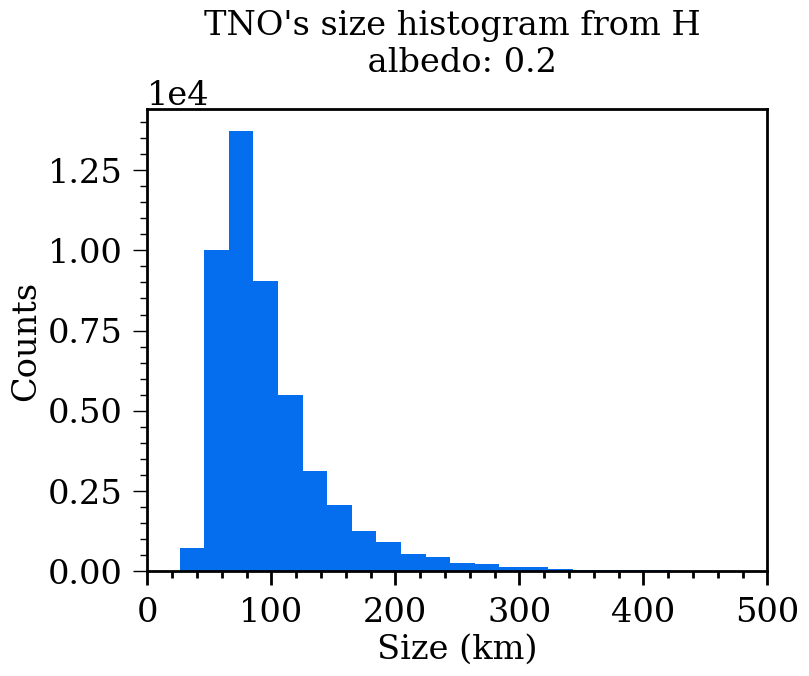

In [18]:
albedo = 0.2
sizes_tnos = estDiamFromHandAlbedo(tnos['mpcH'], albedo=albedo)

n_bins = 100
fig, axs = plt.subplots(1, 1)
axs.hist(sizes_tnos, bins=n_bins)
plt.xlim([0, 500])
plt.xlabel('Size (km)')
plt.ylabel('Counts')
plt.title(f"TNO's size histogram from H \n albedo: {albedo}")

### Eccentricity and inclination vs semi-major axis for different dynamical classes.
Let's now define cuts to clasify the TNOs in the following different dynamical classes: scattering, detached, classical, extreme. Note that definitions in the literature may vary.

In [29]:
max_a_classical = 47
min_a_classical = 40
max_e_classical = 0.24
mask_classical = ((tnos['a'] >= min_a_classical) & (tnos['a'] <= max_a_classical)
                 & (tnos['e'] <= max_e_classical))

min_q_detached = 38
mask_detached = ((tnos['a'] > max_a_classical) & (tnos['e'] > max_e_classical)
                 & (tnos['q'] >= min_q_detached))

mask_scattering = ~mask_classical & (tnos['q'] < min_q_detached)

min_a_extreme = 150
min_q_extreme = 30
mask_extreme = (tnos['a'] > min_a_extreme) & (tnos['q'] > min_q_extreme)

We will now add an extra column to the TNOs table we have defined. This column will contain strings labeling the dynamical class for each object, and will be initialized with the string "Other". 

In [22]:
other_string = "     Other"
classes = np.repeat(other_string, len(tnos))

In [23]:
classes[mask_classical] = 'Classical'
classes[mask_detached] = 'Detached'
classes[mask_scattering] = 'Scattering'
classes[mask_extreme] = 'Extreme'

Add the extra column to the TNO table.


In [24]:
tnos['class'] = classes

In [25]:
class_strings = np.unique(tnos['class'])
print(class_strings)

  class   
----------
     Other
 Classical
  Detached
   Extreme
Scattering


In [26]:
colors = ['xkcd:scarlet', 'xkcd:light purple', 'xkcd:light orange',
          'xkcd:light pink', 'xkcd:cerulean blue']
class_to_color = {}
for i, c in enumerate(class_strings):
    class_to_color[c] = colors[i]
class_to_color

{'     Other': 'xkcd:scarlet',
 'Classical': 'xkcd:light purple',
 'Detached': 'xkcd:light orange',
 'Extreme': 'xkcd:light pink',
 'Scattering': 'xkcd:cerulean blue'}

Class Type | Number 
Classical 17615
Scattering 25613
Detached 1086
Extreme 20
     Other 4240


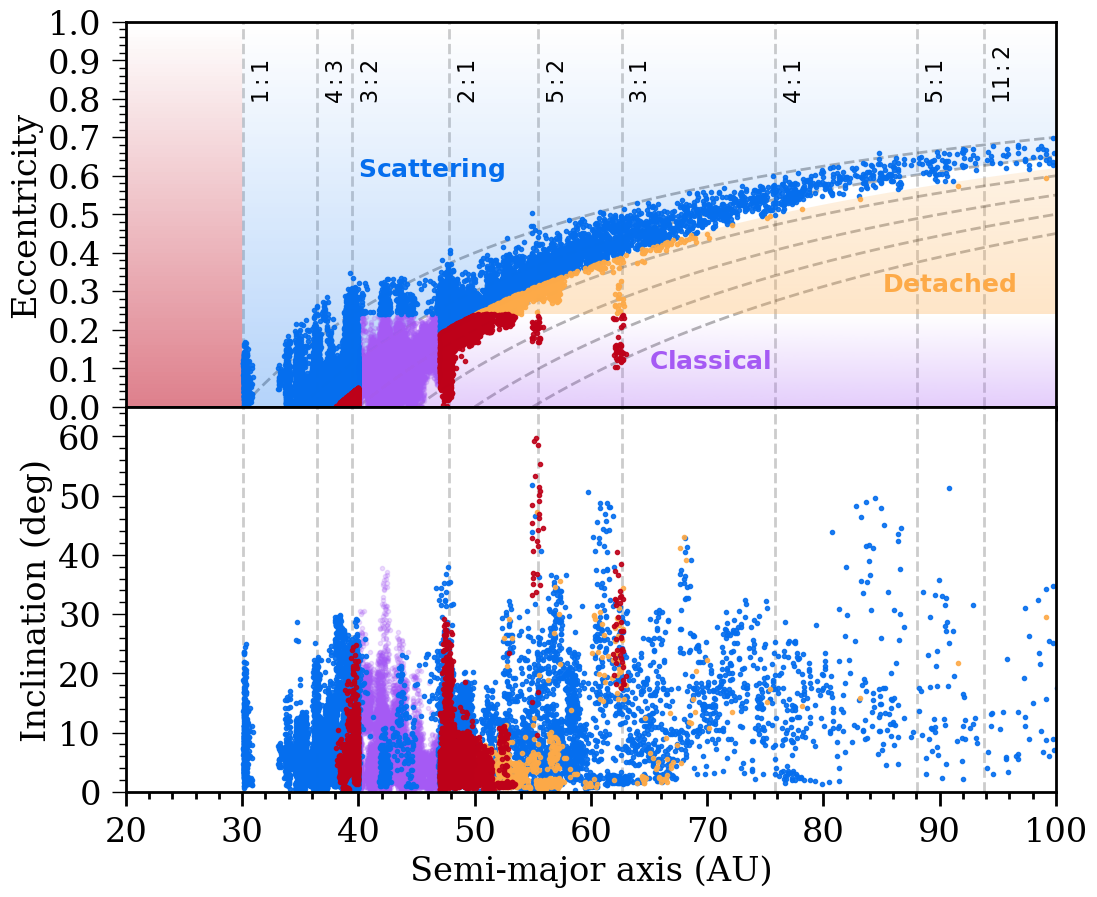

In [31]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
plt.subplots_adjust(wspace=0, hspace=0)
plt.rcParams["image.composite_image"] = False
e = np.linspace(0, 0.99999, 10000)

for i in [30, 35, 40, 45, 50,55]:
    ax1.plot(i/(1-e), e, 'k--', alpha=0.3)

for i,j in zip([1, 2, 3, 3, 4, 4, 5, 5, 11],
               [1, 1, 1, 2, 1, 3, 2, 1, 2]):
    ax1 = plot_resonances(ax1, i, j, 0.8)
    ax2 = plot_resonances(ax2, i, j, )

gradient_fill_inv(30/(1-e), e, ax=ax1, alpha=0.3)

gradient_fill(min_q_detached/(1-e)[e > max_e_classical], e[e>max_e_classical],
              ax = ax1, alpha=0.3, color='xkcd:light orange')

scat = np.append(30/(1-e), 35/(1-e)[::-1])
scat_e = np.append(e, e[::-1])

gradient_fill(scat, scat_e, ax = ax1, alpha=0.3, color='xkcd:cerulean blue')
cl = np.append(35/(1 - e)[e < max_e_classical], 100)
e_cl = np.append(e[e < max_e_classical], 0.24)
gradient_fill(cl, e_cl, ax = ax1, alpha=0.3, color='xkcd:lighter purple')

gradient_fill_inv(np.array([20, 30, 30]), np.array([0,0,1]),
                  ax=ax1, alpha=0.5, color='xkcd:scarlet')

print ("Class Type | Number ")
for c, j in zip(['Classical', 'Scattering', 'Detached', 'Extreme', '     Other'],
                ['xkcd:lighter purple', 'xkcd:cerulean blue', 'xkcd:light orange', 
                 'xkcd:leaf green', 'xkcd:scarlet']):
    b = tnos[tnos['class'] == c]
    print (c, len(b))
    alp = 0.9
    if c == 'Classical':
        alp = 0.2
    ax1.plot(b['a'], b['e'], '.', alpha=alp, color=j)
    ax2.plot(b['a'], b['incl'], '.', alpha=alp, color=j)

ax1.text(40, 0.6, r'$\bf{Scattering}$', rotation=0, color='xkcd:cerulean blue', fontsize=18,)
ax1.text(85, 0.3, r'$\bf{Detached}$', rotation=0, color='xkcd:light orange', fontsize=18,)
ax1.text(65, 0.1, r'$\bf{Classical}$', rotation=0, color='xkcd:lighter purple', fontsize=18,)

ax1.set_xticks(np.arange(20, 110, 10))
ax1.set_yticks(np.arange(0, 1.1, 0.1))
ax2.set_yticks(np.arange(0, 70, 10))

ax1.set_ylim(0, 1)
ax2.set_xlabel('Semi-major axis (AU)')
ax1.set_ylabel('Eccentricity')
ax2.set_ylabel('Inclination (deg)')
ax2.set_ylim(0, 65)
ax1.set_xlim(20, 100)
ax2.set_xlim(20, 100)
fig.set_size_inches(12, 10)
plt.show()

In the following plot, we will extend the plot we just made to include "extreme" TNOs and objects from the Oort Cloud (comets).

Classical 17615
Scattering 25613
Detached 1086
Extreme 20
     Other 4240


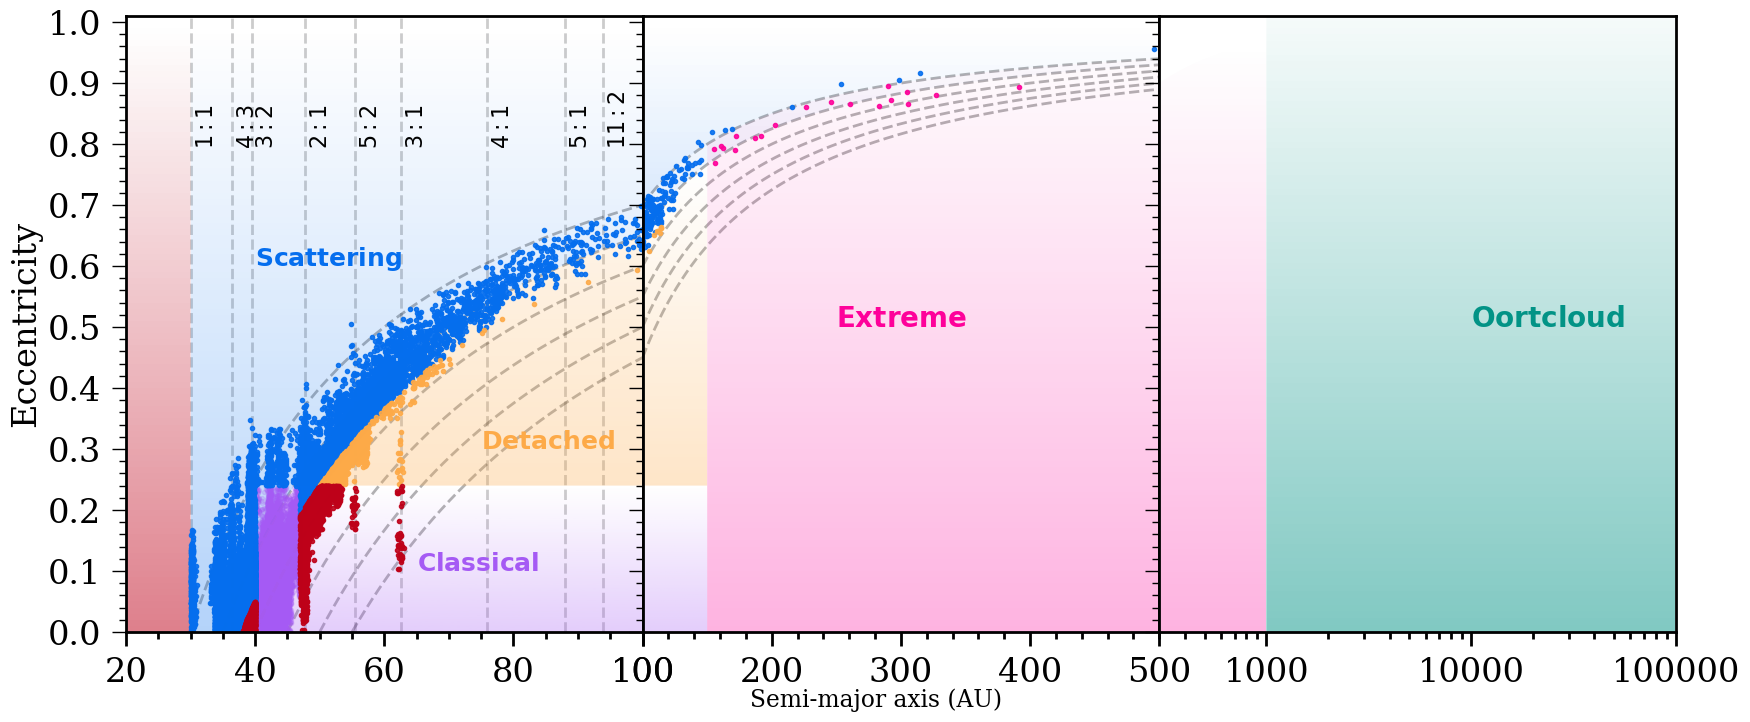

In [34]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,sharey=True)
plt.subplots_adjust(wspace=0, hspace=0)

plt.rcParams["image.composite_image"] = False

e = np.linspace(0,0.9999999,10000)

for i in [30,35, 40, 45, 50,55]:
    ax1.plot(i/(1-e), e, 'k--', alpha=0.3)
    ax2.plot(i/(1-e), e, 'k--', alpha=0.3)
#pl.plot([47.7,1000],[0.24,0.24] )

for i,j in zip([1,2,3,3, 4,4, 5 ,5, 11  ], [1,1,1,2, 1, 3, 2, 1, 2 ]):
    ax1 = plot_resonances(ax1, i, j, 0.8)

gradient_fill_inv(30/(1-e), e, ax=ax1, alpha=0.3)

a_det = 35/(1-e)[e > 0.24]
e_det = e[e>0.24]
gradient_fill(35/(1-e)[e > 0.24], e[e>0.24], ax=ax1, alpha=0.3, color='xkcd:light orange')
gradient_fill(a_det[a_det<150], e_det[a_det<150], ax=ax2, alpha=0.3, color='xkcd:light orange')
scat = np.append(30/(1-e), 35/(1-e)[::-1])
scat_e = np.append(e, e[::-1])

gradient_fill(scat, scat_e, ax=ax1, alpha=0.3, color='xkcd:cerulean blue')
gradient_fill(scat, scat_e, ax=ax2, alpha=0.3, color='xkcd:cerulean blue')
gradient_fill_inv(30/(1-e), e, ax=ax2, alpha=0.5, color='xkcd:cerulean blue')


cl = np.append(35/(1-e)[e < 0.24], 150)
msk = cl<151
e_cl = np.append(e[e<0.24],0.24)

gradient_fill(cl, e_cl, ax=ax1, alpha=0.3, color='xkcd:lighter purple')

gradient_fill(cl[msk], e_cl[msk], ax=ax2, alpha=0.3, color='xkcd:lighter purple')

cl = np.append(35/(1-e)[e < 0.24], 150)
e_cl = np.append(e[e<0.24],0.24)

gradient_fill_inv(np.array([20,30,30]), np.array([0,0,1]), ax=ax1, alpha=0.5, color='xkcd:scarlet')

a = 30/(1-e)
gradient_fill(np.append(150,a[a>150]), np.append(0,e[a>150]), ax=ax2, alpha=0.3, color='xkcd:neon pink')
gradient_fill(np.append(150,a[a<1000]), np.append(0,e[a<1000]), ax=ax3, alpha=0.3, color='xkcd:neon pink')

for c, j in zip(['Classical', 'Scattering', 'Detached', 'Extreme', '     Other'],
                ['xkcd:lighter purple', 'xkcd:cerulean blue', 'xkcd:light orange', 
                 'xkcd:neon pink', 'xkcd:scarlet']):
    b = tnos[tnos['class'] == c]
    print (c, len(b))
    alp = 0.9
    if c == 'Classical':
        alp = 0.2
    ax1.plot(b['a'], b['e'], '.', alpha=alp, color=j)
    ax2.plot(b['a'], b['e'], '.', alpha=alp, color=j)

ax1.text(40, 0.6, r'$\bf{Scattering}$', rotation=0, color='xkcd:cerulean blue', fontsize=18,)
ax1.text(75, 0.3, r'$\bf{Detached}$', rotation=0, color='xkcd:light orange', fontsize=18,)
ax1.text(65, 0.1, r'$\bf{Classical}$', rotation=0, color='xkcd:lighter purple', fontsize=18,)
ax2.text(250, 0.5, r'$\bf{Extreme}$', rotation=0, color='xkcd:neon pink', fontsize=20,)
ax3.text(10000, 0.5, r'$\bf{Oort cloud}$', rotation=0, color='xkcd:teal', fontsize=20,)
    
ax1.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

ax1.set_ylim(0,1.01)
fig.supxlabel('Semi-major axis (AU)')
ax1.set_ylabel('Eccentricity')
ax1.set_xlim(20,100)
ax2.set_xlim(100,500)
ax3.set_xlim(300,100000)
ax3.set_xscale('log')
gradient_fill_inv(np.array([1000,300000,300000]), np.array([0,0,1.1]), ax = ax3, alpha=0.5, color='xkcd:teal')

ax3.set_xticks([1000, 10000, 100000], labels=['1000', '10000', '100000'])
fig.set_size_inches(20,8)
plt.show()

## Using Orbital Elements to construct and visualize orbits 

We can use the orbital elements from the TNOs to visualize their orbits (including comets). We can identify patterns in orbits of different dynamical classes, for example, the clustering of extreme objects that some researchers argue is evidence in favor of the existence of P9/PX. 

## Define functions first 

In [36]:
def q_func(E, a, e):
    """
    Computes the coordinate vector q = (a * (cos(E) - e),
    a * sqrt(1 - e^2) * sin(E), 0),
    on the plane of the ellipse.
    """
    q1 = a * (np.cos(E) - e)
    q2 = a * np.sqrt(1. - e ** 2) * np.sin(E)

    if isinstance(q1, float):
        return np.array([q1, q2, 0.])
    else:
        return np.array([q1, q2, np.zeros_like(q1)])


def R(omega, Omega, i):
    """
    Computes the rotation matrix R = R(Omega, omega, i) that
    maps from the plane of the ellipse to 3D space aligned
    with the ecliptic plane.
    """
    cO = np.cos(np.pi * Omega / 180)
    sO = np.sin(np.pi * Omega / 180)
    co = np.cos(np.pi * omega / 180)
    so = np.sin(np.pi * omega / 180)
    ci = np.cos(np.pi * i / 180)
    si = np.sin(np.pi * i / 180)

    R = np.array([[cO * co - sO * so * ci, -cO * so - sO * co * ci, sO * si],
                  [sO * co + cO * so * ci, -sO * so + cO * co * ci, -cO * si],
                  [si * so, si * co, ci]])

    return R


def full_ellipse(a, e, i, Omega, omega):
    """
    Computes the coordinates of the full ellipse in 3D space.
    """
    E = np.linspace(0, 2 * np.pi, 2000)
    q_vec = q_func(E, a, e)
    Rot = R(omega, Omega, i)
    x = np.einsum('ij, j...', Rot, q_vec)

    return x

Calculte the ellipse per object, and append it to the catalog as an extra column

In [37]:
ellipse_vec = []
for i in tnos:
    ellipse_vec.append(full_ellipse(i['a'], i['e'], i['incl'], i['node'], i['peri']))
tnos['ellipse_vec'] = ellipse_vec

Let's plot 100 objects, so it doesn't take forever and it doesn't get too crowded.

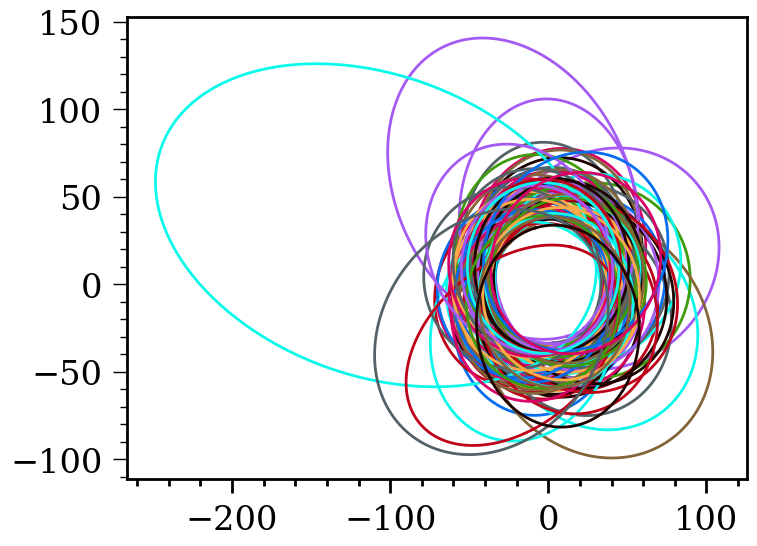

In [38]:
for i in tnos[:100]:
    plt.plot(i['ellipse_vec'][:,0], i['ellipse_vec'][:,1])

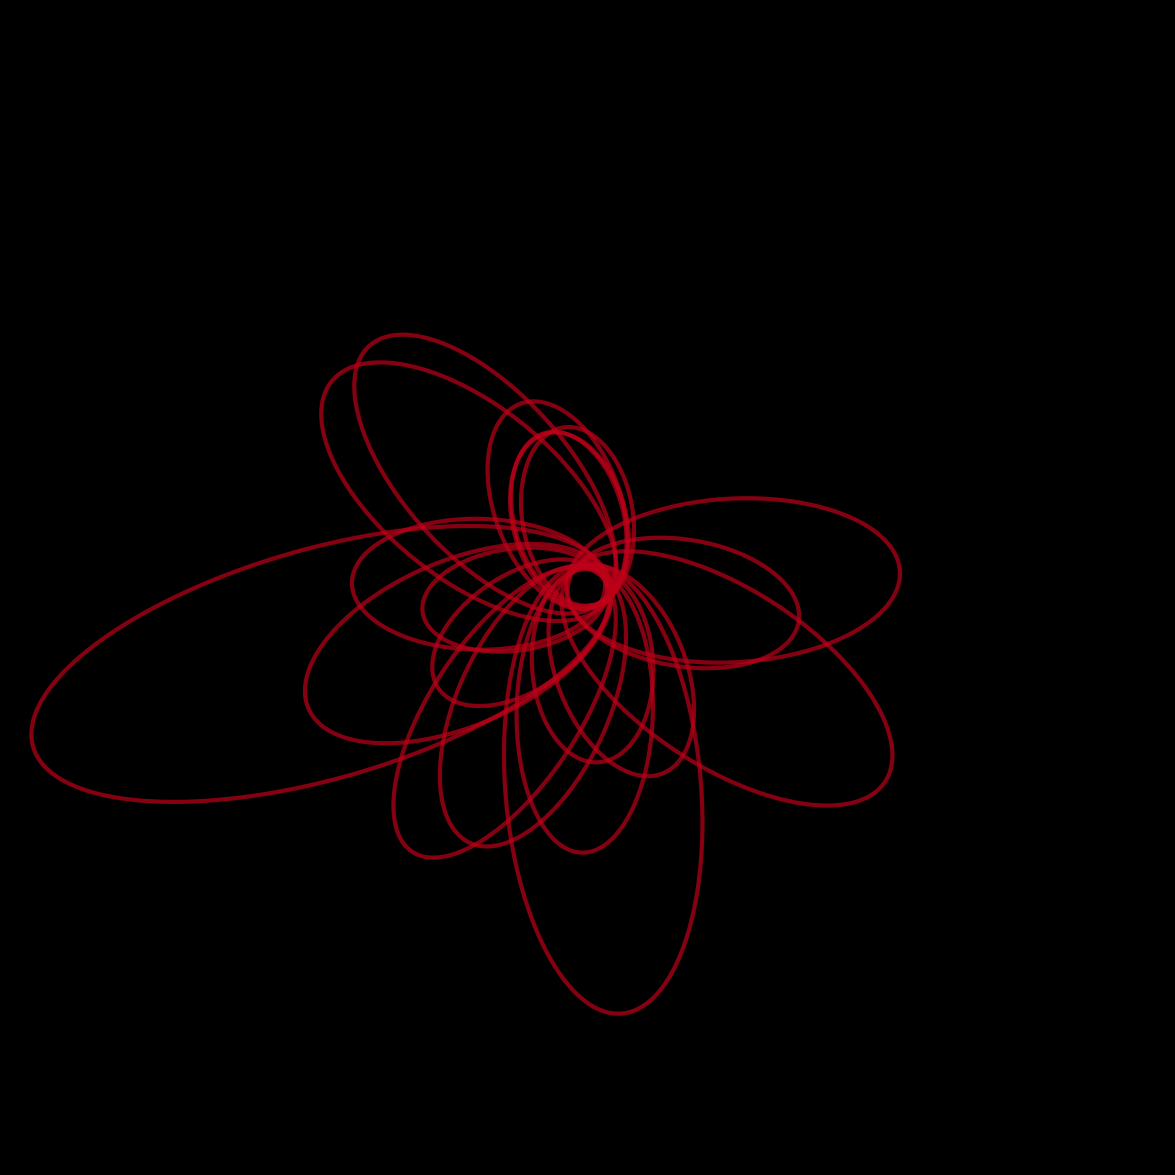

In [42]:
fig = plt.figure()
fig.set_size_inches(15,15)
plt.rcParams['figure.facecolor'] = 'black'
plt.axes().set_aspect('equal')
colors = {'Resonant' : '#9ed4bf', 'Classical' : '#9ed4bf', 'Scattering': '#9ed4bf',
          'Detached' : '#9ed4bf', 'Oort cloud' : '#9ed4bf', 'Inner Centaur' : '#9ed4bf'}
alphas = {'Resonant' : 0.1, 'Classical' : 0.1, 'Scattering' : 0.1, 'Detached': 0.1, 'Inner Centaur' : 0.1, 'Oort cloud' : 0.1}
alphas_dist = {'Resonant' : 0.2, 'Classical' : 0.2, 'Scattering' : 0.2, 'Detached': 0.2, 'Inner Centaur' : 0.2, 'Oort cloud' :0.2}
tnos.sort('a')
for i in tnos[tnos['class'] == 'Extreme']:
    plt.plot(i['ellipse_vec'][:,0], i['ellipse_vec'][:,1], 'xkcd:scarlet',
             linewidth=3, alpha=0.7)
plt.xlim(-1000,1000)
plt.ylim(-1000,1000)
plt.axis('off')
plt.show()

In [43]:
# From Pedro: " The above results is expected, and it also says a lot about expected results from LSST!
#The S3M model predates the whole Planet 9 stuff (and is old enough that these more exotic 
# populations are not representative of what we have learned from the more recent surveys)
#But this does an excellent job of showing that LSST will see the signal or not easily!"

#### Excersises for the learner

- Define cuts and plot the "Resonant" class in the e-i-a plots. 
